In [1]:
import numpy as np
import pandas as pd
import glob
import tensorflow as tf
from tensorflow.keras import layers, losses
import os
import time

In [2]:
os.environ["CUDA_VISIBLE_DEVICES"] = "2"

In [3]:
datas = glob.glob('20201203/wifi/dataRssi_at_*.txt')

In [4]:
datas[0].split("/")[-1].split("_")[-1].split(".")[0]

'45'

In [5]:
train_data = []
origin_data = []
train_label = []
for data in datas:
    load_data = np.loadtxt(data)#f.read()
    load_data = load_data[:200,:15].astype(int)
    load_data[load_data==0] = -100
    load_data = load_data/100 + 1
    #print(load_data.shape)
    for i in range(len(load_data)):
        origin_data.append(load_data[i])
        mask = np.random.rand((15))
        mask = (mask>0.1).astype(int)
        noise = np.random.normal(scale = 0.05,size=(15))
        load_data[i]*mask
        load_data[i]+noise
        train_data.append(load_data[i])
        train_label.append(data.split("/")[-1].split("_")[-1].split(".")[0])
    #print(load_data.shape)    
    
    #print(np.array(train_data).shape)
origin_data = np.array(origin_data).astype('float32') 
train_data = np.array(train_data).astype('float32')
train_label = np.array(pd.get_dummies(train_label)).astype('float32')
#train_label = train_label.reshape(len(train_label),1)
train_val_split = np.random.rand(len(train_data)) < 0.70
train_x = train_data[train_val_split]
train_o = origin_data[train_val_split]
train_y = train_label[train_val_split]
val_x = train_data[~train_val_split]
val_o = origin_data[~train_val_split]
val_y = train_label[~train_val_split]
BUFFER_SIZE = train_x.shape[0]
BATCH_SIZE = train_x.shape[0]
train_dataset = tf.data.Dataset.from_tensor_slices((train_x,train_o,train_y))
train_dataset = train_dataset.shuffle(BUFFER_SIZE).batch(BATCH_SIZE)
valid_dataset = tf.data.Dataset.from_tensor_slices((val_x,val_o)).batch(len(val_x))

In [6]:
np.array(train_label).shape

(10000, 50)

In [7]:
class DenseTranspose(tf.keras.layers.Layer):
    def __init__(self, dense, activation=None, **kwargs):
        self.dense = dense
        self.activation = tf.keras.activations.get(activation)
        super().__init__(**kwargs)
    def build(self, batch_input_shape):
        self.biases = self.add_weight(name='bias',shape=[self.dense.input_shape[-1]],initializer="zeros")
        super().build(batch_input_shape)
    def call(self, inputs):
        z = tf.matmul(inputs, self.dense.weights[0], transpose_b = True)
        return self.activation(z + self.biases)

In [8]:
#mirrored_strategy = tf.distribute.MirroredStrategy(devices=["/gpu:0","/gpu:1"])
#with mirrored_strategy.scope():

input = tf.keras.layers.Input(shape=(15), name='input_layer1')
#flatten = tf.keras.layers.Flatten()(input)
dense1 = tf.keras.layers.Dense(32, activation='relu')
dense2 = tf.keras.layers.Dense(24, activation='relu')
dense3 = tf.keras.layers.Dense(16, activation='relu')
model_encoder = dense1(input)
model_encoder = dense2(model_encoder)
model_encoder = dense3(model_encoder)
model_down = tf.keras.Model(inputs=[input], outputs=model_encoder,name = "encoder")#input1, input2,input3,input4,input5,input6,input7,input8,input9,input10
#model_down.summary()
#input_encoder = tf.keras.layers.Input(shape=(15), name='input_layer2')
input2 = tf.keras.layers.Input(shape=(16), name='input_layer2')
model_decoder = DenseTranspose(dense3, activation = 'relu')(input2)
model_decoder = DenseTranspose(dense2, activation = 'relu')(model_decoder)
model_decoder = DenseTranspose(dense1, activation = 'relu')(model_decoder)
model_up = tf.keras.Model(inputs=[input2], outputs=model_decoder,name = "decoder")

#model_encoder_decoder.summary()
input3 = tf.keras.layers.Input(shape=(16), name='input_layer3')
model_ann = tf.keras.layers.Dense(16, activation='relu')(input3)
model_ann = tf.keras.layers.Dropout(0.5, noise_shape=None, seed=None)(model_ann)
model_ann = tf.keras.layers.Dense(16, activation='relu')(model_ann)
model_ann = tf.keras.layers.Dropout(0.5, noise_shape=None, seed=None)(model_ann)
model_ann = tf.keras.layers.Dense(16, activation='relu')(model_ann)
#model_ann = tf.keras.layers.Dropout(0.5, noise_shape=None, seed=None)(model_ann)
#model_ann = tf.keras.layers.Dense(16, activation='relu')(model_ann)
#model_ann = tf.keras.layers.Dropout(0.5, noise_shape=None, seed=None)(model_ann)
#model_ann = tf.keras.layers.Dense(16, activation='relu')(model_ann)
#model_ann = tf.keras.layers.Dropout(0.5, noise_shape=None, seed=None)(model_ann)
model_ann = tf.keras.layers.Dense(50, activation='softmax')(model_ann)
model_ANN = tf.keras.Model(inputs=[input3], outputs=model_ann,name = "ann")

input_full = tf.keras.layers.Input(shape=(15), name='input_layer4')
encoder_out = model_down(input_full)
decoder_out = model_up(encoder_out)
ann_out = model_ANN(encoder_out)
#model_encoder_decoder_ann = tf.keras.Model(inputs=[input_full],outputs=[decoder_out],name = 'encoder_decoder_ann')
model_encoder_decoder_ann = tf.keras.Model(inputs=[input_full],outputs=[decoder_out,ann_out],name = 'encoder_decoder_ann')
#optimizer = tf.keras.optimizers.SGD(learning_rate=1e-2, momentum=1e-5)
#model_encoder_decoder_ann.compile(optimizer = 'sgd', 
#                                  loss={'AE_out1': 'mean_squared_error','place_out2': 'categorical_crossentropy'}),
#                                  loss_weights={'AE_out1': 0.5,'place_out2': 0.5},
#                                  metrics=['accuracy'])

In [9]:
model_encoder_decoder_ann.summary()

Model: "encoder_decoder_ann"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_layer4 (InputLayer)       [(None, 15)]         0                                            
__________________________________________________________________________________________________
encoder (Model)                 (None, 16)           1704        input_layer4[0][0]               
__________________________________________________________________________________________________
decoder (Model)                 (None, 15)           1775        encoder[1][0]                    
__________________________________________________________________________________________________
ann (Model)                     (None, 50)           1666        encoder[1][0]                    
Total params: 3,441
Trainable params: 3,441
Non-trainable params: 0
____________

In [10]:
len(model_encoder_decoder_ann.trainable_variables)

17

In [11]:
shared_vars = model_encoder_decoder_ann.trainable_variables[:6]
decode_vars = model_encoder_decoder_ann.trainable_variables[6:9]
ann_vars = model_encoder_decoder_ann.trainable_variables[9:]

In [12]:
def model_loss(output,t_o,t_y):
    #print("in loss")
    output_AE , output_label = output
    #output_AE = output
    mse = losses.MeanSquaredError()
    AE_loss = mse(t_o,output_AE)
    ann_loss =losses.categorical_crossentropy(t_y,output_label)
    total_loss = AE_loss*100 + ann_loss
    
    return AE_loss,ann_loss

In [13]:
learning_rate_A = tf.keras.optimizers.schedules.ExponentialDecay(
initial_learning_rate=1e-4, decay_steps=5000, decay_rate=0.9)
optimizer_A = tf.optimizers.SGD(learning_rate=learning_rate_A , momentum=1e-5)
learning_rate_B = tf.keras.optimizers.schedules.ExponentialDecay(
initial_learning_rate=1e-3, decay_steps=10000, decay_rate=0.8)
optimizer_B = tf.optimizers.Adam(learning_rate=1e-3)#learning_rate_B)

In [14]:
#@tf.function

def train_step(t_x,t_o,t_y):
  
    with tf.GradientTape() as AE_tape,tf.GradientTape() as ANN_tape:
        output = model_encoder_decoder_ann(t_x, training=True)
        #AE_loss = model_loss(output,t_o,t_y)
        AE_loss,ANN_loss = model_loss(output,t_o,t_y)
        #gradients = tape.gradient(total_loss, shared_vars+decode_vars)
        #optimizer_A.apply_gradients(zip(gradients, shared_vars+decode_vars))

    if np.random.rand() < 0.5:
        #print("AE")
        gradients_AE = AE_tape.gradient(AE_loss, shared_vars+decode_vars)
        #gradients_AE = [tf.clip_by_value(g, -1,1) for g in gradients_AE]

        #print("AE gradient : ",gradients_AE)
        optimizer_A.apply_gradients(zip(gradients_AE, shared_vars+decode_vars))
    
    else:
        #print("ANN")
        gradients_ANN = ANN_tape.gradient(ANN_loss, shared_vars+ann_vars)
        #print("ANN gradient : ",gradients_ANN)
        #gradients_ANN = [tf.clip_by_value(g, -1,1) for g in gradients_ANN] 
        optimizer_B.apply_gradients(zip(gradients_ANN, shared_vars+ann_vars))
    
    return np.array(AE_loss).mean(),np.array(ANN_loss).mean()

In [15]:
checkpoint_dir = './wifi_checkpoints/checkpoints_1222'
checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt_dropout_model_{epoch}")
checkpoint = tf.train.Checkpoint(optimizerA=optimizer_A,
                                 optimizerB=optimizer_B,
                                 model_encoder_decoder_ann=model_encoder_decoder_ann,
                                 model_down=model_down)

In [16]:
class PrintLR(tf.keras.callbacks.Callback):
  def on_epoch_end(self, epoch, logs=None):
    print('\nLearning rate for epoch {} is {}'.format(epoch + 1,
                                                      model_encoder_decoder.optimizer.lr.numpy()))

In [17]:
def validation(v_x,v_o,v_y):
    output = model_encoder_decoder_ann(v_x)
    #output_AE = output
    output_AE , output_label = output
    mse = losses.MeanSquaredError()
    AE_loss = mse(v_o,output_AE)
    ann_loss = losses.categorical_crossentropy(v_y,output_label)
    total_loss = AE_loss*100 + ann_loss
    #print(output_label[200])
    #print(v_y[200])
    #print(ann_loss)
    #print("AE loss : {},".format(np.array(AE_loss).mean()))
    print("AE loss : {}, ANN loss : {}, Total loss : {}".format(np.array(AE_loss).mean(),np.array(ann_loss).mean(),np.array(total_loss).mean()))

In [18]:
val_x.shape

(3039, 15)

In [19]:
def train(epochs):
  for epoch in range(epochs):
    start = time.time()
    all_AE = []
    all_ANN =[]
    for x,o,y in train_dataset:
        #AE_loss = train_step(x,o,y)
        AE_loss,ANN_loss = train_step(x,o,y)
        all_AE.append(AE_loss)
        all_ANN.append(ANN_loss)
    #print("train AE loss : {}".format(np.array(all_AE).mean()))
    print("train AE loss : {}, train ANN loss : {}".format(np.array(all_AE).mean(),np.array(all_ANN).mean()))
    validation(val_x,val_o,val_y)
    checkpoint.save(file_prefix=checkpoint_prefix)
    print("learning rate A : ",optimizer_A._decayed_lr(tf.float32))
    print("learning rate B : ",optimizer_B._decayed_lr(tf.float32))
    print(f'Time for epoch {epoch + 1} is {time.time() - start:.4f} sec')


In [20]:
a = [0., 0., 1., 0., 0., 0., 0., 0., 0.]#[0.11685812, 0.11185785, 0.11026918, 0.10764945, 0.10728354, 0.11020868,
 #0.10912149, 0.11363789, 0.11311384]#[0, 1, 0,0,0,0,0,0,0]
b = [2.4371104e-08, 4.2344610e-11, 9.9997091e-01, 4.9084689e-13, 6.4827432e-06,
 2.1712562e-08, 3.4163491e-11, 3.0665456e-11, 2.2567538e-05]
tf.keras.losses.categorical_crossentropy(a,b)

<tf.Tensor: id=475, shape=(), dtype=float32, numpy=2.908749e-05>

In [21]:
train(2000)

train AE loss : 0.07074526697397232, train ANN loss : 3.9126532077789307
AE loss : 0.07167715579271317, ANN loss : 3.9124388694763184, Total loss : 11.080153465270996
learning rate A :  tf.Tensor(1e-04, shape=(), dtype=float32)
learning rate B :  <tf.Variable 'Adam/learning_rate:0' shape=() dtype=float32, numpy=0.001>
Time for epoch 1 is 0.4852 sec
train AE loss : 0.07177841663360596, train ANN loss : 3.9125783443450928
AE loss : 0.07167460024356842, ANN loss : 3.9124388694763184, Total loss : 11.079898834228516
learning rate A :  tf.Tensor(9.999789e-05, shape=(), dtype=float32)
learning rate B :  <tf.Variable 'Adam/learning_rate:0' shape=() dtype=float32, numpy=0.001>
Time for epoch 2 is 0.1063 sec
train AE loss : 0.07177584618330002, train ANN loss : 3.912745714187622
AE loss : 0.07263150066137314, ANN loss : 3.912421703338623, Total loss : 11.17557144165039
learning rate A :  tf.Tensor(9.999789e-05, shape=(), dtype=float32)
learning rate B :  <tf.Variable 'Adam/learning_rate:0' shap

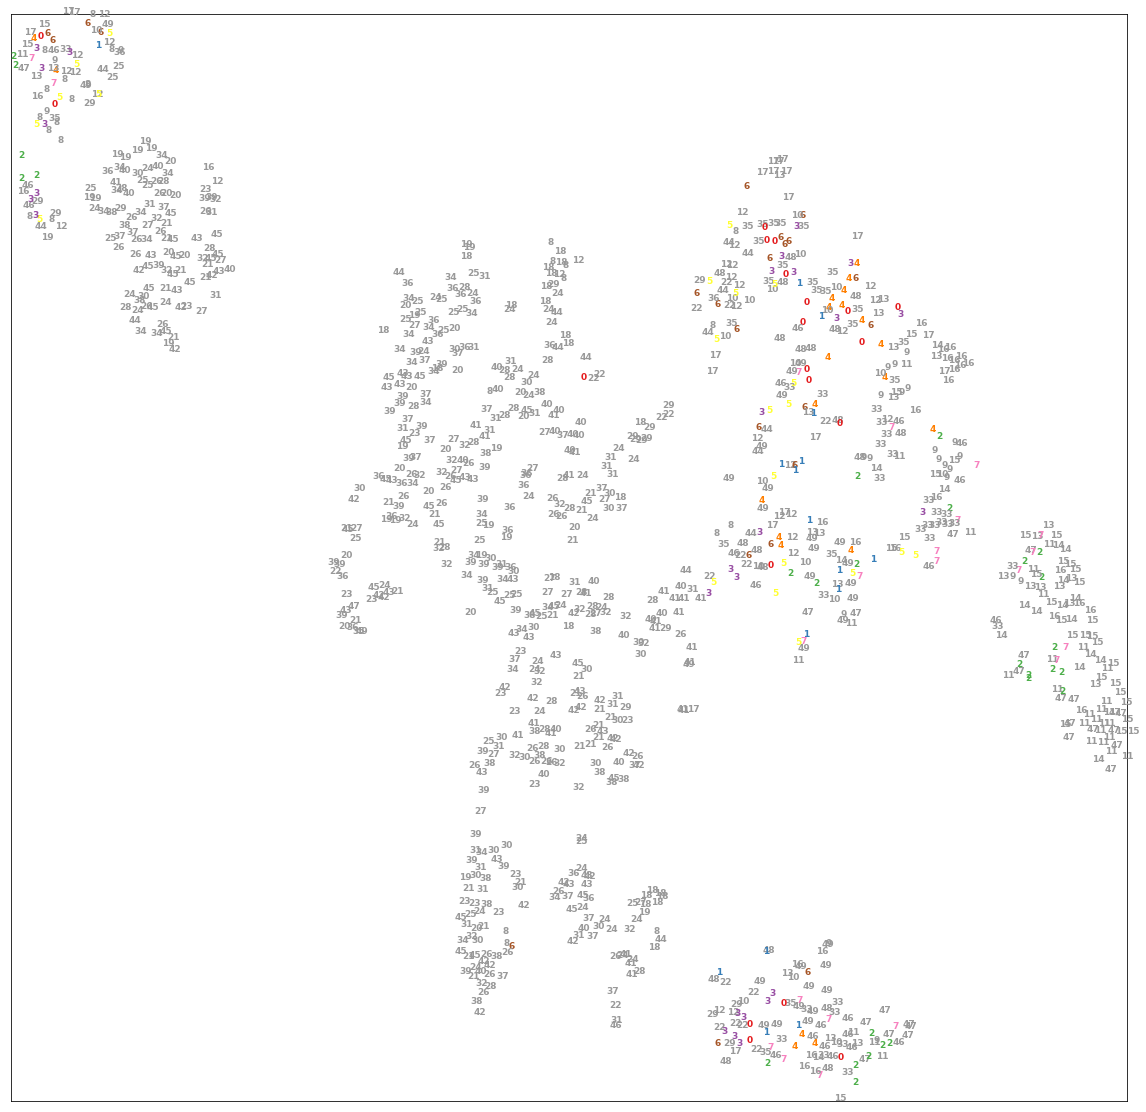

In [22]:
val_latent = model_down(val_x)
from sklearn import manifold, datasets
import matplotlib.pyplot as plt
train_val_split = np.random.rand(len(val_latent)) < 0.4
X_tsne = manifold.TSNE(n_components=2, init='pca', n_iter=5000, method='exact').fit_transform(val_latent[train_val_split])
y = val_y[train_val_split].argmax(axis=1).reshape([-1,1])
x_min, x_max = X_tsne.min(0), X_tsne.max(0)
X_norm = (X_tsne - x_min) / (x_max - x_min)
plt.figure(figsize=(20, 20))
for i in range(X_norm.shape[0]):
    plt.text(X_norm[i, 0], X_norm[i, 1], str(y[i,0]), color=plt.cm.Set1(y[i,0]), 
             fontdict={'weight': 'bold', 'size': 9})
plt.xticks([])
plt.yticks([])
plt.savefig("result/wifi_pca_latent16")
plt.show()

In [23]:
y = val_y[train_val_split].argmax(axis=1).reshape([-1,1])

In [24]:
y.shape

(1195, 1)

In [25]:
model_encoder_decoder_ann.weights[0][0]

<tf.Tensor: id=928898, shape=(32,), dtype=float32, numpy=
array([-0.44223818,  0.34099025,  0.22630885,  0.3531104 ,  0.01432228,
        0.28596947,  0.20210937, -0.18629518,  0.34547195, -0.10634677,
       -0.45710066,  0.11655647,  0.05475373,  0.08871596,  0.08869676,
       -0.03721688,  0.13843378, -0.02852063,  0.02335411,  0.22630875,
        0.3144795 , -0.30959225,  0.29096606,  0.4847697 ,  0.32044274,
       -0.08135206, -0.40763628, -0.03506229, -0.0032622 ,  0.06158475,
        0.29149553,  0.15948303], dtype=float32)>

In [26]:
model_down.weights[0][0]

<tf.Tensor: id=928903, shape=(32,), dtype=float32, numpy=
array([-0.44223818,  0.34099025,  0.22630885,  0.3531104 ,  0.01432228,
        0.28596947,  0.20210937, -0.18629518,  0.34547195, -0.10634677,
       -0.45710066,  0.11655647,  0.05475373,  0.08871596,  0.08869676,
       -0.03721688,  0.13843378, -0.02852063,  0.02335411,  0.22630875,
        0.3144795 , -0.30959225,  0.29096606,  0.4847697 ,  0.32044274,
       -0.08135206, -0.40763628, -0.03506229, -0.0032622 ,  0.06158475,
        0.29149553,  0.15948303], dtype=float32)>